In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x

In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
#     drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [11]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg, preProcNum = 0):
#    Xg = cleanupImage(id)

    if ( preProcNum != 0):
        if preProcNum & 4: # rotate
            Xg = np.rot90(Xg)
            
        if preProcNum %4 == 1: # vflip
            Xg = np.flip(Xg,0)
        elif preProcNum %4 == 2: # hflip
            Xg = np.flip(Xg,1)
        elif preProcNum %4 == 3: # hflip+vflip
            Xg = np.flip(np.flip(Xg,1),0)

    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    Xg = crop_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id, preProcNum = 0):
    Xg = read_image(id)
    return img_preprocnoread(Xg,preProcNum)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


-0.804691 27.1617
[[-0.17632617 -0.12471178 -0.02148302  0.01133325 -0.02626297]
 [-0.17966296 -0.15230891 -0.0976008  -0.08636351 -0.11859703]
 [-0.18633655 -0.20750314 -0.24983639 -0.28175703 -0.30326512]
 [-0.22135624 -0.25732577 -0.32926491 -0.38014516 -0.40996665]
 [-0.28472203 -0.30177683 -0.33588639 -0.38152796 -0.43870151]]


1

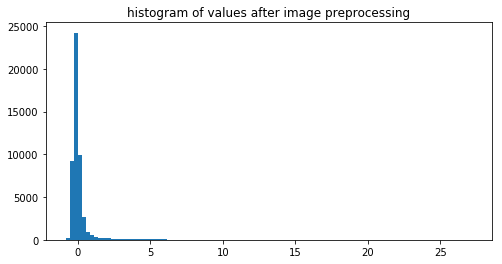

In [12]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [13]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [14]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [15]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,1.877420e+05,1.877420e+05
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358,7.877701e+10,4.648110e+09
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273,9.461819e+10,5.529011e+09
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006,1.552387e+10,1.144774e+09
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278,4.931738e+10,2.906879e+09
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858,1.076465e+11,6.027530e+09
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [16]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [17]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,185.303775,25.672447,0.557644,0.058701,38.101843,0.487867,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,57.111612,18.944782,0.194465,0.032567,19.838329,0.270663,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,154.486425,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,186.753000,24.400580,0.489779,0.052300,35.043089,0.434670,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,221.979375,40.093400,0.602560,0.075600,47.500516,0.628319,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [18]:
random.seed(42)

df = df.sample(frac=1).reset_index(drop=True)

In [19]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
0,1237679167158747217,23.76075,15.48772,0.512861,0.0721,46.098264,308.9999939714159,0.599230,11.351,0.037,308.999994,2.243882e+11,1.911690e+10,True
1,1237661358076919942,170.32005,47.05395,0.467735,0.0546,31.837723,234.00000163487024,0.453786,10.508,0.012,234.000002,3.221069e+10,8.900142e+08,True
2,1237659119328165980,230.41650,44.79981,0.436516,0.0667,36.297368,285.85712824548995,0.554350,10.172,0.046,285.857128,1.485936e+10,1.573887e+09,True
3,1237661966353432773,176.04465,41.44909,0.436516,0.1275,69.384026,546.4285612106323,1.059664,11.342,0.013,546.428561,2.197860e+11,6.578987e+09,True
4,1237651736850006060,224.11650,2.20688,0.407380,0.0289,14.677334,123.85714000889233,0.240191,10.346,0.016,123.857140,2.218196e+10,8.172138e+08,True


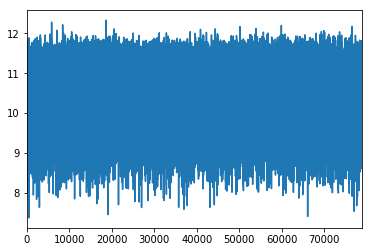

In [20]:
df.logMstar.plot()

In [21]:
print(len(df.SDSS_ID.values))

78851


In [22]:
# crap instruction to make the auto execution stop here :p

### call img_preproc on all images, per batches of "chunkSize"
### Generate features based on the preprocessed images, pretrained networks and flux densities

In [23]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+'-'+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [24]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [25]:
postImgFeatureNames = ['norm.flux.sum', 'norm.flux.min',
                       'norm.flux.max', 'norm.flux.mean', 
                       'norm.flux.std', 'center.flux', 
                       'aroundCenter.flux']
preImgFeatureNames = ['pre.flux.sum', 'pre.flux.min', 
                      'pre.flux.max', 'pre.flux.mean',
                      'pre.flux.std', 'pre.center.flux',
                      'pre.aroundCenter.flux', 'width']
distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]


def getFeatures(preProcessingNum):
    Xg3r50 = []
    Xg3vgg16 = []
    postImgFeatures = []
    csize=2
    preImgFeatures = []

    maxChunkNumber = math.ceil(len(ids)/chunkSize)
    chunkStart = 0
    # for chunkStart in tqdm(range(0, 3)):
    
    # do the loading by chunk to avoid consuming too much memory
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

        Xg_ = []
        pre_ex_ = []

        # preprocess the image and collect some raw image stats
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            X = read_image(ids[i])
            Xg_.append(img_preprocnoread(X, preProcessingNum))
            pre_ex_.append([
                X.sum(),
                X.min(),
                X.max(),
                X.mean(),
                X.std(),
                X[X.shape[0]//2,X.shape[1]//2],
                np.mean(X[X.shape[0]//2-csize:X.shape[0]//2+csize,X.shape[1]//2-csize:X.shape[1]//2+csize]), # mean center
                X.shape[0], 
            ])

        # reformat the postprocessing
        pre_ex = np.stack(pre_ex_)
        Xg = np.stack(Xg_)

        # collect some post processing stats
        post_ex = np.hstack([
            np.sum(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.min(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.max(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.mean(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            np.std(Xg.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
            Xg[:,112,112].reshape(valuesInThisChunk,1),       # center
            np.mean(Xg[:,112-csize:112+csize,112-csize:112+csize].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
            ])

        # prepare correct dimension to feed to imagenet networks
        Xg3 = np.zeros((valuesInThisChunk,224,224,3))
        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        # do r50 prediction
        Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
        Xg3vgg16_ = vgg16.predict(Xg3)


        if chunkStart == 0:
            Xg3r50 = Xg3r50_
            Xg3vgg16 = Xg3vgg16_
            preImgFeatures = pre_ex
            postImgFeatures = post_ex
        else:
            Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
            Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
            preImgFeatures = np.concatenate([preImgFeatures,pre_ex], axis=0)
            postImgFeatures = np.concatenate([postImgFeatures,post_ex], axis=0)



    # add features from the data itself (distance)
    Distance = df.Distance.values[:N].reshape(N,1)

    Xg3f = np.hstack ( ( 
            Xg3r50, 
            Xg3vgg16, 
            Distance,
            1/Distance,
            Distance**2,
            1/(Distance**2),
            Distance**3,
            1/(Distance**3),
            np.log(Distance),
            1/np.log(Distance),
            np.log(Distance**2),
            1/np.log(Distance**2),
            np.log(Distance)**2,
            1/np.log(Distance)**2,
            preImgFeatures,
            postImgFeatures
            ) )


    Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
                + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
                + [prefixThisRound+'.'+ n for n in distanceNames]
                + [prefixThisRound+'.'+ n for n in preImgFeatureNames]
                + [prefixThisRound+'.'+ n for n in postImgFeatureNames])

#     print(len(Xg3fNames), Xg3f.shape)
    
    return Xg3f, Xg3fNames

numFeatures = 2048 + 1000 + len(postImgFeatureNames) + len(preImgFeatureNames) + len(distanceNames)
    

In [26]:
def getLGBMModelsWithCV(trainSet, YSet):
    kf = KFold(n_splits=nSplits,shuffle=True, random_state=220477)

    cvtrainpreds = np.zeros([len(Xg3f),nSplits])
    models = []
    xis, linxis = [],[]
    counter = 0
    for tix, vix in kf.split(trainSet):
        X_train, X_test = trainSet[tix], trainSet[vix]
        Y_train, Y_test = YSet[tix], YSet[vix]

        lgb_train = lgbm.Dataset(X_train, Y_train)
        lgb_eval = lgbm.Dataset(X_test, Y_test)

        gbm = lgbm.train(lgbm_params,
                           lgb_train,
                           num_boost_round=20000,
                           valid_sets=[lgb_train,lgb_eval],  # eval training data
                           verbose_eval=100,
                           early_stopping_rounds=100
                        )
        models.append(gbm)

        p = gbm.predict(X_test)
        chiSq = xi2(Y_test,p,err[vix])
        linChiSq = xi2(10**Y_test,10**p,err_lin[vix])
        xis.append(chiSq)
        linxis.append(linChiSq)
        print(counter,chiSq,linChiSq)    

        cvtrainpreds[vix,counter] = p
        counter = counter+1
        
    return models, cvtrainpreds, xis, linxis

# models, cvtrainpreds, xis, linxis = getModels(Xg3f[:M], Y[:M])

# print(models, cvtrainpreds)

# print(xis, linxis)


In [27]:
def getLGBMModelsNoCV(trainSet, YSet, errSet, errlinSet):
    cvtrainpreds = np.zeros([len(trainSet),1])
    models = []
    xis, linxis = [],[]
    counter = 0

    tix, vix = list(range(0,int(len(trainSet)*0.9))), list(range(int(len(trainSet)*0.9),len(trainSet)))
    
    X_train, X_test = trainSet[tix], trainSet[vix]
    Y_train, Y_test = YSet[tix], YSet[vix]

    lgb_train = lgbm.Dataset(X_train, Y_train)
    lgb_eval = lgbm.Dataset(X_test, Y_test)

    gbm = lgbm.train(lgbm_params,
                       lgb_train,
                       num_boost_round=maxBoostRuns,
                       valid_sets=[lgb_train,lgb_eval],  # eval training data
                       verbose_eval=100,
                       early_stopping_rounds=100
                    )
    models.append(gbm)

    p = gbm.predict(X_test)
    chiSq = xi2(Y_test,p,errSet[vix])
    linChiSq = xi2(10**Y_test,10**p,errlinSet[vix])
    xis.append(chiSq)
    linxis.append(linChiSq)
    print(counter,chiSq,linChiSq)    

    cvtrainpreds[vix,counter] = p
    counter = counter+1
        
    return models, cvtrainpreds, xis, linxis


In [28]:
# from keras.models import model9d

# def get9DModel(trainSet, YSet):
#     model = model9d(trainSet.shape[1])
#     model.fit(trainSet,YSet,verbose=1)
#     return model

ImportError: cannot import name 'model9d'

In [29]:
TRAIN = 0
TEST = 4
FEATURES = 0
TRUTH = 1
ERROR = 2
LINERROR = 3



# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [30]:
N = int(len(df.SDSS_ID.values))
M = int(N*.9)

prefixThisRound = 'sp'
for i in runNameParams:
    prefixThisRound = prefixThisRound + '-' + i

prefixThisRound = prefixThisRound + '-model6'
    
chunkSize = 200
nSplits = 3
reloadImagesAndPreprocess = 1
numPreprocessing = 2
nSplits = 1

maxBoostRuns = 20000
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


N = int(N*0.1)
M = int(M*0.1)


In [31]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [ ]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

In [32]:
ttaPredictions = np.zeros([numPreprocessing,nSplits,N-M])

data = list(range(8))

data[TRAIN+FEATURES] = np.ones([0,numFeatures])
data[TRAIN+TRUTH] = np.ones([0])
data[TRAIN+ERROR] = np.ones([0])
data[TRAIN+LINERROR] = np.ones([0])
data[TEST+FEATURES] = np.ones([0,numFeatures])
data[TEST+TRUTH] = np.ones([0])
data[TEST+ERROR] = np.ones([0])
data[TEST+LINERROR] = np.ones([0])

fileName = prefixThisRound + 'allFeatures' + str(numPreprocessing) + '.npy'

if reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName)):
    for curTTA in range(numPreprocessing):
        a, Xg3fNames = getFeatures(curTTA)

        data[TRAIN+FEATURES] = np.vstack([data[TRAIN+FEATURES],a[:M]])
        data[TRAIN+TRUTH] = np.hstack([data[TRAIN+TRUTH],Y[:M]])
        data[TEST+FEATURES] = np.vstack([data[TEST+FEATURES],a[M:]])
        data[TEST+TRUTH] = np.hstack([data[TEST+TRUTH],Y[M:]])
        data[TRAIN+ERROR] = np.hstack([data[TRAIN+ERROR],err[:M]])
        data[TRAIN+LINERROR] = np.hstack([data[TRAIN+LINERROR], err_lin[:M]])
        data[TEST+ERROR] = np.hstack([data[TEST+ERROR],err[M:]])
        data[TEST+LINERROR]  = np.hstack([data[TEST+LINERROR] , err_lin[M:]])

    np.save(fileName, data)
else:
    data = np.load(fileName)




100%|██████████| 40/40 [01:04<00:00,  1.37s/it]


In [33]:
models, cvtrainpreds, xis, linxis = getLGBMModelsNoCV(data[TRAIN+FEATURES], data[TRAIN+TRUTH], data[TRAIN+ERROR], data[TRAIN+LINERROR])

ppreds = np.zeros([len(models),data[TEST+FEATURES].shape[0]])
for i, m in zip(range(len(models)),models):
    mp = m.predict(data[TEST+FEATURES])
    ppreds[i] = mp

cvpred = ppreds.mean(axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.346958	valid_1's rmse: 0.345555
[200]	training's rmse: 0.245419	valid_1's rmse: 0.250697
[300]	training's rmse: 0.20929	valid_1's rmse: 0.220103
[400]	training's rmse: 0.191007	valid_1's rmse: 0.206303
[500]	training's rmse: 0.178801	valid_1's rmse: 0.198951
[600]	training's rmse: 0.169501	valid_1's rmse: 0.193688
[700]	training's rmse: 0.161966	valid_1's rmse: 0.19013
[800]	training's rmse: 0.155694	valid_1's rmse: 0.187549
[900]	training's rmse: 0.150368	valid_1's rmse: 0.18596
[1000]	training's rmse: 0.145514	valid_1's rmse: 0.18442
[1100]	training's rmse: 0.141225	valid_1's rmse: 0.18312
[1200]	training's rmse: 0.137362	valid_1's rmse: 0.182378
[1300]	training's rmse: 0.133851	valid_1's rmse: 0.181561
[1400]	training's rmse: 0.130538	valid_1's rmse: 0.180724
[1500]	training's rmse: 0.127467	valid_1's rmse: 0.179965
[1600]	training's rmse: 0.124545	valid_1's rmse: 0.179437
[1700]	training's rmse:

[14000]	training's rmse: 0.0182796	valid_1's rmse: 0.166429
[14100]	training's rmse: 0.0180274	valid_1's rmse: 0.16641
[14200]	training's rmse: 0.0177788	valid_1's rmse: 0.166401
[14300]	training's rmse: 0.0175353	valid_1's rmse: 0.166398
Early stopping, best iteration is:
[14279]	training's rmse: 0.0175847	valid_1's rmse: 0.166395
0 64.9465160624 64.552872269


In [34]:
print("Iteration : {}".format(numPreprocessing))
chiSq = xi2(data[TEST+TRUTH],cvpred,data[TEST+ERROR])
linChiSq = xi2(10**data[TEST+TRUTH],10**cvpred,data[TEST+LINERROR])
print(chiSq)
print(linChiSq)

# ttaPredictions[curTTA] = ppreds
    

Iteration : 2
67.7680028295
77.5366504091


In [ ]:
ppreds.reshape((numPreprocessing,-1)).mean(axis=0)

In [35]:
# print(M)
# print(trainXg3fStacked.shape)
# testXg3fStacked.shape
# ttaPredictions.shape
# ppreds.shape

mpred = ppreds.reshape((numPreprocessing,-1)).mean(axis=0)
chiSq = xi2(data[TEST+TRUTH][:len(mpred)],mpred,data[TEST+ERROR][:len(mpred)])
linChiSq = xi2(10**data[TEST+TRUTH][:len(mpred)],10**mpred,data[TEST+LINERROR][:len(mpred)])
print(chiSq)
print(linChiSq)


65.3773183087
75.3634222114


In [92]:
# test keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization

model = Sequential()
model.add(Dense(3000, input_shape=(data[TRAIN+FEATURES].shape[1],), activation = 'relu',))
model.add(BatchNormalization())
model.add(Dense(1500, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0),
      loss='mse',
      metrics=['accuracy'])

model.fit(data[TRAIN+FEATURES], data[TRAIN+TRUTH], batch_size=100, epochs=500, validation_split = 0.1)
# model.compile(optimizer='adam',      loss='mse', metrics=['accuracy'])

x = model.predict(data[TEST+FEATURES])
print(x)

Train on 12772 samples, validate on 1420 samples
Epoch 1/500
12772/12772 [==============================] - 1s - loss: 23.6014 - acc: 2.3489e-04 - val_loss: 10.3412 - val_acc: 0.0000e+00
Epoch 2/500
12772/12772 [==============================] - 1s - loss: 3.7427 - acc: 5.4807e-04 - val_loss: 5.6842 - val_acc: 0.0000e+00
Epoch 3/500
12772/12772 [==============================] - 1s - loss: 2.2477 - acc: 3.1319e-04 - val_loss: 18.8492 - val_acc: 0.0000e+00
Epoch 4/500
12772/12772 [==============================] - 1s - loss: 1.5662 - acc: 3.1319e-04 - val_loss: 52.3977 - val_acc: 7.0423e-04
Epoch 5/500
12772/12772 [==============================] - 1s - loss: 1.1236 - acc: 3.9148e-04 - val_loss: 3.3844 - val_acc: 7.0423e-04
Epoch 6/500
12772/12772 [==============================] - 1s - loss: 0.9046 - acc: 7.0467e-04 - val_loss: 10.0795 - val_acc: 0.0000e+00
Epoch 7/500
12772/12772 [==============================] - 1s - loss: 0.7425 - acc: 9.3956e-04 - val_loss: 25.5780 - val_acc: 7.04

12772/12772 [==============================] - 1s - loss: 0.2057 - acc: 9.3956e-04 - val_loss: 12.0433 - val_acc: 0.0014
Epoch 61/500
12772/12772 [==============================] - 1s - loss: 0.2094 - acc: 7.8296e-04 - val_loss: 5.0013 - val_acc: 7.0423e-04
Epoch 62/500
12772/12772 [==============================] - 1s - loss: 0.2056 - acc: 9.3956e-04 - val_loss: 5.3820 - val_acc: 7.0423e-04
Epoch 63/500
12772/12772 [==============================] - 1s - loss: 0.2044 - acc: 0.0010 - val_loss: 2.0358 - val_acc: 0.0014
Epoch 64/500
12772/12772 [==============================] - 1s - loss: 0.2058 - acc: 0.0010 - val_loss: 6.3783 - val_acc: 0.0014
Epoch 65/500
12772/12772 [==============================] - 1s - loss: 0.2059 - acc: 9.3956e-04 - val_loss: 2.2950 - val_acc: 0.0014
Epoch 66/500
12772/12772 [==============================] - 1s - loss: 0.1999 - acc: 9.3956e-04 - val_loss: 4.6459 - val_acc: 7.0423e-04
Epoch 67/500
12772/12772 [==============================] - 1s - loss: 0.2027

12772/12772 [==============================] - 1s - loss: 0.1627 - acc: 9.3956e-04 - val_loss: 6.6840 - val_acc: 0.0014
Epoch 122/500
12772/12772 [==============================] - 1s - loss: 0.1689 - acc: 0.0011 - val_loss: 4.0219 - val_acc: 0.0014
Epoch 123/500
12772/12772 [==============================] - 1s - loss: 0.1650 - acc: 9.3956e-04 - val_loss: 6.8545 - val_acc: 0.0014
Epoch 124/500
12772/12772 [==============================] - 1s - loss: 0.1642 - acc: 0.0010 - val_loss: 3.9769 - val_acc: 0.0000e+00
Epoch 125/500
12772/12772 [==============================] - 1s - loss: 0.1640 - acc: 9.3956e-04 - val_loss: 11.0797 - val_acc: 0.0014
Epoch 126/500
12772/12772 [==============================] - 1s - loss: 0.1628 - acc: 9.3956e-04 - val_loss: 3.3331 - val_acc: 0.0014
Epoch 127/500
12772/12772 [==============================] - 1s - loss: 0.1607 - acc: 0.0010 - val_loss: 6.8452 - val_acc: 0.0014
Epoch 128/500
12772/12772 [==============================] - 1s - loss: 0.1662 - ac

12772/12772 [==============================] - 1s - loss: 0.1430 - acc: 0.0011 - val_loss: 12.5171 - val_acc: 0.0014
Epoch 183/500
12772/12772 [==============================] - 1s - loss: 0.1436 - acc: 0.0011 - val_loss: 3.3541 - val_acc: 7.0423e-04
Epoch 184/500
12772/12772 [==============================] - 1s - loss: 0.1480 - acc: 0.0010 - val_loss: 12.2506 - val_acc: 7.0423e-04
Epoch 185/500
12772/12772 [==============================] - 1s - loss: 0.1409 - acc: 0.0010 - val_loss: 3.6726 - val_acc: 0.0000e+00
Epoch 186/500
12772/12772 [==============================] - 1s - loss: 0.1483 - acc: 0.0010 - val_loss: 7.7970 - val_acc: 7.0423e-04
Epoch 187/500
12772/12772 [==============================] - 1s - loss: 0.1381 - acc: 0.0011 - val_loss: 5.6663 - val_acc: 7.0423e-04
Epoch 188/500
12772/12772 [==============================] - 1s - loss: 0.1400 - acc: 0.0010 - val_loss: 12.2277 - val_acc: 0.0014
Epoch 189/500
12772/12772 [==============================] - 1s - loss: 0.1409 - 

12772/12772 [==============================] - 1s - loss: 0.1288 - acc: 0.0011 - val_loss: 4.0515 - val_acc: 0.0000e+00
Epoch 244/500
12772/12772 [==============================] - 1s - loss: 0.1303 - acc: 0.0011 - val_loss: 11.7252 - val_acc: 0.0014
Epoch 245/500
12772/12772 [==============================] - 1s - loss: 0.1302 - acc: 9.3956e-04 - val_loss: 5.7061 - val_acc: 0.0000e+00
Epoch 246/500
12772/12772 [==============================] - 1s - loss: 0.1253 - acc: 0.0010 - val_loss: 11.2382 - val_acc: 0.0014
Epoch 247/500
12772/12772 [==============================] - 1s - loss: 0.1329 - acc: 0.0010 - val_loss: 4.5782 - val_acc: 0.0000e+00
Epoch 248/500
12772/12772 [==============================] - 1s - loss: 0.1281 - acc: 0.0010 - val_loss: 4.6484 - val_acc: 0.0000e+00
Epoch 249/500
12772/12772 [==============================] - 1s - loss: 0.1288 - acc: 0.0010 - val_loss: 6.8121 - val_acc: 7.0423e-04
Epoch 250/500
12772/12772 [==============================] - 1s - loss: 0.1281

12772/12772 [==============================] - 1s - loss: 0.1271 - acc: 0.0010 - val_loss: 4.8441 - val_acc: 0.0014
Epoch 305/500
12772/12772 [==============================] - 1s - loss: 0.1179 - acc: 0.0010 - val_loss: 9.3103 - val_acc: 0.0000e+00
Epoch 306/500
12772/12772 [==============================] - 1s - loss: 0.1204 - acc: 0.0011 - val_loss: 5.9725 - val_acc: 7.0423e-04
Epoch 307/500
12772/12772 [==============================] - 1s - loss: 0.1229 - acc: 0.0011 - val_loss: 8.0035 - val_acc: 7.0423e-04
Epoch 308/500
12772/12772 [==============================] - 1s - loss: 0.1197 - acc: 0.0010 - val_loss: 5.3002 - val_acc: 7.0423e-04
Epoch 309/500
12772/12772 [==============================] - 1s - loss: 0.1157 - acc: 9.3956e-04 - val_loss: 10.7951 - val_acc: 0.0000e+00
Epoch 310/500
12772/12772 [==============================] - 1s - loss: 0.1187 - acc: 0.0010 - val_loss: 6.4108 - val_acc: 7.0423e-04
Epoch 311/500
12772/12772 [==============================] - 1s - loss: 0.1

12772/12772 [==============================] - 1s - loss: 0.1166 - acc: 9.3956e-04 - val_loss: 9.9512 - val_acc: 7.0423e-04
Epoch 366/500
12772/12772 [==============================] - 1s - loss: 0.1140 - acc: 0.0011 - val_loss: 4.7435 - val_acc: 0.0014
Epoch 367/500
12772/12772 [==============================] - 1s - loss: 0.1109 - acc: 0.0011 - val_loss: 9.0925 - val_acc: 0.0014
Epoch 368/500
12772/12772 [==============================] - 1s - loss: 0.1114 - acc: 0.0010 - val_loss: 4.6087 - val_acc: 7.0423e-04
Epoch 369/500
12772/12772 [==============================] - 1s - loss: 0.1126 - acc: 0.0010 - val_loss: 10.5974 - val_acc: 0.0014
Epoch 370/500
12772/12772 [==============================] - 1s - loss: 0.1144 - acc: 8.6126e-04 - val_loss: 7.3386 - val_acc: 7.0423e-04
Epoch 371/500
12772/12772 [==============================] - 1s - loss: 0.1097 - acc: 0.0010 - val_loss: 14.4762 - val_acc: 0.0000e+00
Epoch 372/500
12772/12772 [==============================] - 1s - loss: 0.1143

12772/12772 [==============================] - 1s - loss: 0.1016 - acc: 0.0010 - val_loss: 4.4235 - val_acc: 0.0000e+00
Epoch 427/500
12772/12772 [==============================] - 1s - loss: 0.1062 - acc: 0.0010 - val_loss: 11.6633 - val_acc: 0.0014
Epoch 428/500
12772/12772 [==============================] - 1s - loss: 0.1011 - acc: 0.0011 - val_loss: 6.5928 - val_acc: 0.0014
Epoch 429/500
12772/12772 [==============================] - 1s - loss: 0.1026 - acc: 0.0011 - val_loss: 7.0653 - val_acc: 0.0014
Epoch 430/500
12772/12772 [==============================] - 1s - loss: 0.1023 - acc: 0.0010 - val_loss: 6.4585 - val_acc: 0.0014
Epoch 431/500
12772/12772 [==============================] - 1s - loss: 0.1002 - acc: 0.0011 - val_loss: 6.5111 - val_acc: 0.0014
Epoch 432/500
12772/12772 [==============================] - 1s - loss: 0.1085 - acc: 9.3956e-04 - val_loss: 6.7100 - val_acc: 0.0014
Epoch 433/500
12772/12772 [==============================] - 1s - loss: 0.1040 - acc: 0.0010 - 

12772/12772 [==============================] - 1s - loss: 0.1047 - acc: 9.3956e-04 - val_loss: 5.7477 - val_acc: 0.0014
Epoch 488/500
12772/12772 [==============================] - 1s - loss: 0.1064 - acc: 0.0010 - val_loss: 4.4318 - val_acc: 7.0423e-04
Epoch 489/500
12772/12772 [==============================] - 1s - loss: 0.1026 - acc: 0.0011 - val_loss: 10.3072 - val_acc: 0.0000e+00
Epoch 490/500
12772/12772 [==============================] - 1s - loss: 0.1011 - acc: 9.3956e-04 - val_loss: 5.8064 - val_acc: 0.0014
Epoch 491/500
12772/12772 [==============================] - 1s - loss: 0.1051 - acc: 0.0010 - val_loss: 10.3842 - val_acc: 0.0000e+00
Epoch 492/500
12772/12772 [==============================] - 1s - loss: 0.1027 - acc: 0.0011 - val_loss: 4.1537 - val_acc: 0.0014
Epoch 493/500
12772/12772 [==============================] - 1s - loss: 0.1063 - acc: 0.0010 - val_loss: 7.4535 - val_acc: 7.0423e-04
Epoch 494/500
12772/12772 [==============================] - 1s - loss: 0.1031

2.28093135092e+56


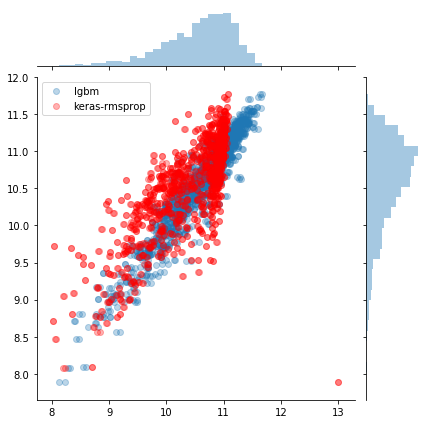

In [107]:
linChiSq = xi2(10**data[TEST+TRUTH],10**x,data[TEST+LINERROR])
print(linChiSq)

g = sns.jointplot(x=cvpred, y=data[TEST+TRUTH], alpha=.3)
g.x = x[:,0].clip(0,13)
g.y = data[TEST+TRUTH]
g.plot_joint(plt.scatter, alpha=.3, c='r')

plt.legend(['lgbm', 'keras-rmsprop'])
# sns.jointplot(x=x[:,0], y=cvpred)

# sns.jointplot(x=cvpred, y=data[TEST+TRUTH])

In [104]:
qsd =x

print(qsd.clip(0,15).max())

15.0


In [ ]:
data[TEST+FEATURES][:4]